# Hypothesis

This notebook serves as a demo of the basic features and functionality of the Python tool **Hypothesis**.

## What is Hypothesis

Hypothesis is a tool that allows us to write and generate tests that generate and allow for fuzzing over a large variety of data without actually manually making all the tests. The key features mentioned are **property-based-testing** using `@given`, **strategies** for primitive and more complex data types, **shrinking** to find the simplest possible counter-example, and **stateful testing** to test with defined rules and checking invariants.

## 1. Basic Usage: `@given` and Strategies

The core of Hypothesis is the `@given` decorator, which takes **strategies** that define how to generate data. Let's test a simple `add` function.

In [14]:
from hypothesis import given, strategies as st

def add(a, b):
    """A simple function to add two numbers."""
    return a + b

# This is a property-based test!
# It states that for any two integers a and b, add(a, b) should equal a + b.

@given(a=st.integers(), b=st.integers())
def test_addition_property(a, b):
    print(f"Testing with a={a}, b={b}") 
    assert add(a, b) == a + b

test_addition_property()

Testing with a=0, b=0
Testing with a=22149, b=0
Testing with a=22149, b=8905417486324510575
Testing with a=-266919774, b=0
Testing with a=-266919774, b=122
Testing with a=-17, b=0
Testing with a=-17, b=587
Testing with a=14523, b=0
Testing with a=14523, b=-12982
Testing with a=-96849633820791080953592401014527383176, b=0
Testing with a=-96849633820791080953592401014527383176, b=32600
Testing with a=-96849633820791080953592401014527383176, b=-96849633820791080953592401014527383176
Testing with a=-31888, b=1480329228
Testing with a=1480329228, b=1480329228
Testing with a=-24952, b=107
Testing with a=107, b=107
Testing with a=1259512388, b=-119
Testing with a=1259512388, b=1259512388
Testing with a=-22786, b=-76497760958168568639823815944500326806
Testing with a=-22786, b=-22786
Testing with a=-794545257, b=23200
Testing with a=23200, b=23200
Testing with a=5386260833022709603, b=7812
Testing with a=5386260833022709603, b=5386260833022709603
Testing with a=-27489, b=26145
Testing with a=2

Notice how Hypothesis tries a wide range of integers: positives, negatives, and zero. If the assertion had failed, Hypothesis would have reported it.

## 2. Shrinking and Replaying

Hypothesis's superpower is finding the *simplest possible* failing example, also known as **shrinking**. To illustrate this, we can start with a sorting function which we introduce a bug into. The bug is that if both 0 and 1 are present in our target list, we return an erroneous list.

We define a custom strategy that generates a list of 1 to 10 values from -5 through 5.

In [40]:
# clear the hypothesis cache
import shutil
try:
    shutil.rmtree('.hypothesis')
except:
    print('no cache')

In [41]:
from hypothesis import find, settings, note
from typing import List

def buggy_sort(numbers: List[int]) -> List[int]:
    '''A sorting function with a bug: if both 0 and 1 are present, it returns [999].'''
    if 0 in numbers and 1 in numbers:
        return [999] #oh no our sort is wrong
    return sorted(numbers)

# defined strategy
list_strategy = st.lists(
    st.integers(min_value=-5, max_value=5),
    min_size=1,
    max_size=10
)

# record the sizes of the inputs we see to visualize later
seen_inputs = []

# check function
def check_sort(numbers: List[int]):
    seen_inputs.append(len(numbers))
    print(f"Checking example: {numbers}")
    return buggy_sort(numbers) != sorted(numbers)

# find a failing example
def run_find():
    print("Searching for example")
    failing_example = find(list_strategy, check_sort)
    print(f" {failing_example}")

run_find()

Searching for example
Checking example: [0]
Checking example: [-2]
Checking example: [4]
Checking example: [4, 4, -3]
Checking example: [-2, 5]
Checking example: [-2, -3]
Checking example: [-4]
Checking example: [-3]
Checking example: [-2, 5, -1]
Checking example: [-2, 5, -1, -4, -5]
Checking example: [2]
Checking example: [-5]
Checking example: [-5, 1]
Checking example: [-5, -5]
Checking example: [3]
Checking example: [-3, 1]
Checking example: [-4, 3]
Checking example: [-3, 2]
Checking example: [4, 1]
Checking example: [4, 1, 1]
Checking example: [1, 1, 1]
Checking example: [1, 1]
Checking example: [-4, -4]
Checking example: [-4, -4, 3, -5]
Checking example: [-4, -4, 3, 3]
Checking example: [-4, -4, 3, -4]
Checking example: [-5, -1]
Checking example: [0, -5]
Checking example: [0, -5, 2]
Checking example: [-5, -5, 2]
Checking example: [-5, 2, 2]
Checking example: [2, 2, 2]
Checking example: [2, -1]
Checking example: [4, -1]
Checking example: [4, -1, -1, 2]
Checking example: [-1, -1, -1

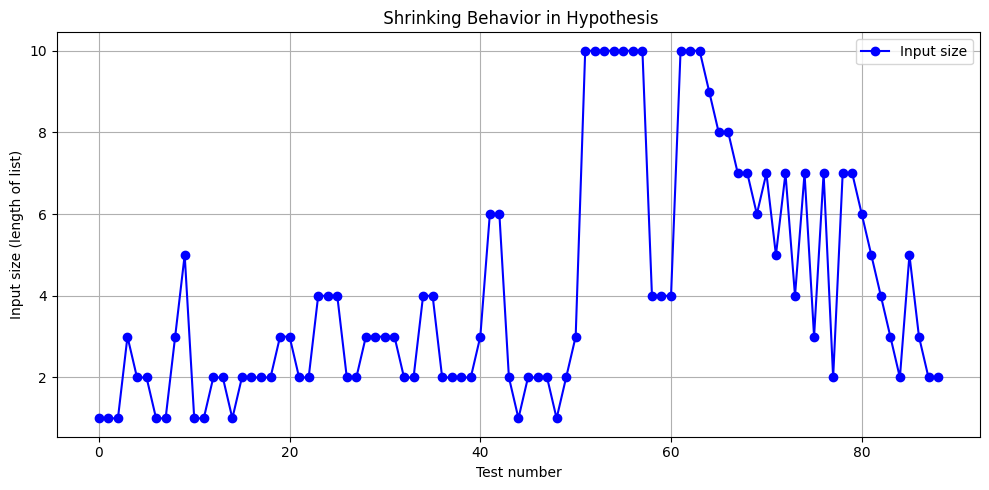

In [42]:
import matplotlib.pyplot as plt

sizes = seen_inputs
plt.figure(figsize=(10, 5))
plt.plot(sizes, marker='o', linestyle='-', color='blue', label='Input size')
plt.xlabel('Test number')
plt.ylabel('Input size (length of list)')
plt.title(' Shrinking Behavior in Hypothesis')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

You might note it shrank it down to the simplest possible case that still causes the error, which is [0, 1] in this case.

#### Replaying Failures

When a test fails, Hypothesis saves the failing example (this is also why we cleared the hypothesis cache in the beginning). You can use the `@example` decorator to add it as a permanent regression test case, ensuring the bug never comes back.

In [43]:
from hypothesis import given, example


@given(st.lists(st.integers()))
@example([0, 1])  
def test_buggy_sort(numbers):
    try:
        assert buggy_sort(numbers) == sorted(numbers)
    except AssertionError:
        print(f"Test failed for input: {numbers}")

test_buggy_sort()

print("Test with @example ran.")


Test failed for input: [0, 1]
Test with @example ran.


To run tests without referring to the failing example in the cache, we can configure that using the settings decorator.

In [45]:
@given(st.lists(st.integers()))
@settings(database=None, max_examples=10)
def test_bugs(numbers):
    print(f"Testing with input: {numbers}")
    assert buggy_sort(numbers) == sorted(numbers)

test_bugs()

Testing with input: []
Testing with input: [0]
Testing with input: [34, 5, 26516]
Testing with input: [91, -24021]
Testing with input: [18862, -5, -32, 10887, -31021, -29472, 11256, 31441]
Testing with input: [5194, 70, 5, -1842, -56]
Testing with input: [23031, 22965, -15711, 20504]
Testing with input: [-125, -111, 27215, -9471, 1728916942]
Testing with input: [-1780, -22703, -18798, -122, -20, 6567075288317969585, -28247, -1640, 13012]
Testing with input: [9323]


## Filtering and Transformations (`.filter()`, `assume`, `.map()`)

Hypothesis provides several ways to narrow down the set of possible examples to generate.

In [ ]:
from hypothesis import assume

count_examples = {"filter": 0, "assume": 0, "early return": 0}
count_pass = {"filter": 0, "assume": 0, "early return": 0}

@settings(max_examples=50)
@given(st.integers().filter(lambda x: x % 2 == 0), st.integers().filter(lambda x: x % 2 == 0))
def test_filter(a, b):
    count_examples["filter"] += 1

    assert (a+b) % 2 == 0

    count_pass["filter"] += 1

@settings(max_examples=50)
@given(st.integers(), st.integers())
def test_assume(a, b):
    count_examples["assume"] += 1

    assume(a % 2 == 0 and b % 2 == 0)
    assert (a+b) % 2 == 0

    count_pass["assume"] += 1

@settings(max_examples=50)
@given(st.integers(), st.integers())
def test_early_return(a, b):
    count_examples["early return"] += 1

    if a % 2 != 0 or b % 2 != 0:
        return
    assert (a+b) % 2 == 0

    count_pass["early return"] += 1

test_filter()
test_assume()
test_early_return()

print(f"{'method':15s} | {'examples created':20s} | {'success rate':>11s}")
print("="*60)
for method in "filter", "assume", "early return":
    print(f"{method:15s} | {count_examples[method]:20d} | {count_pass[method]:10d}/50")

In [ ]:
import time

@settings(max_examples=500)
@given(st.integers().map(lambda x: x*2), st.integers().map(lambda x: x*2))
def test_mapping(a, b):
    assert (a+b) % 2 == 0

@settings(max_examples=500)
@given(st.integers().filter(lambda x: x % 2 == 0), st.integers().filter(lambda x: x % 2 == 0))
def test_filtering(a, b):
    assert (a+b) % 2 == 0

for method, fn in ("mapping", test_mapping), ("filtering", test_filtering):
    start_time = time.perf_counter()
    fn()
    end_time = time.perf_counter()
    elapsed = end_time - start_time
    print(f"{method:8s} | time: {elapsed:8.4f}s")

### Takeaways
1. A successful example is one where an assert does not fail which is why early return generates exactly 50 examples that are not considered failures.
2. `.assume()` will not make progress towards max examples if assumption fails, but will still invoke the function (think about side effects if assumption is in middle of body)
3. Should prefer `.filter()` to `.assume()` and avoid early return when using Hypothesis.
4. Consider using mapping over filtering for potential perfomance gains.

Hypothesis also claims that simple `.filter()` can be sometimes be optimized beyond trivial rejection sampling unlike `.assume()`

## 4. Custom and Composite Strategies

If you need to generate objects, you can use the `@composite` decorator, which lets you build new strategies from existing ones.

In [ ]:
from hypothesis.strategies import composite
from dataclasses import dataclass

@dataclass
class LotteryTicket:
    participant_id: int
    ticket_hash: str
    
#draw() draws a value from another strategy.

@composite
def ticket_strategy(draw):
    """A strategy to generate Ticket objects."""
    participant_id = draw(st.integers(min_value=0000, max_value=9999))
    ticket_hash = draw(st.text(alphabet="0123456789abcdef", min_size=3, max_size=8))
    return LotteryTicket(participant_id=participant_id, ticket_hash=ticket_hash)

@given(ticket=ticket_strategy())
def test_ticket_creation(ticket):
    print(f"Generated Ticket: {ticket}")
    assert isinstance(ticket, LotteryTicket)
    assert ticket.participant_id >= 0000
    assert ticket.participant_id <= 9999
    assert len(ticket.ticket_hash) >= 3
    assert len(ticket.ticket_hash) <= 8

test_ticket_creation()

We can also generate a value that depends on a value from another strategy. 

In [ ]:
@composite
def ordered_ticket_pair(draw):
    #first ticket
    t1_id = draw(st.integers(min_value=0, max_value=9998)) #1 less in case t2_id is 9999
    t1_hash = draw(st.text(alphabet="0123456789abcdef", min_size=3, max_size=8))
    ticket1 = LotteryTicket(participant_id=t1_id, ticket_hash=t1_hash)
    
    #second ticket, where its participant_id > first ticket's participant_id
    t2_id = draw(st.integers(min_value=t1_id+1, max_value=9999))
    t2_hash = draw(st.text(alphabet="0123456789abcdef", min_size=3, max_size=8))
    ticket2 = LotteryTicket(participant_id=t2_id, ticket_hash=t2_hash)
    
    return (ticket1, ticket2)

@given(ordered_ticket_pair())
def test_ordered_tickets(pair):
    ticket1, ticket2 = pair
    print(ticket1, ticket2)
    #the second participant_id is > the first
    assert ticket1.participant_id < ticket2.participant_id

    for t in pair:
        assert 3 <= len(t.ticket_hash) <= 8

test_ordered_tickets()

`@data` is an alternative to `@composite` if you don't want to finish generating the entire input before running the test. Some cases of this are if 
1. You don't want to generate all the input until some initial assertions have passed.
2. You have some complicated control flow which makes it necessary to generate something in the middle of the test.

`@data` lets you mix test code and generation code. You can dynamically call `data.draw(strategy)` any number of times inside the test. Each draw is independent except when you pass dependent parameters, and you don't need a separate `@composite` strategy if all your drawing logic fits in one test.

In [ ]:
from hypothesis.strategies import data

@given(data())
def test_ordered_tickets(data):
    t1_id = data.draw(st.integers(min_value=0, max_value=9998)) #1 less in case t2_id is 9999
    t1_hash = data.draw(st.text(alphabet="0123456789abcdef", min_size=3, max_size=8))
    ticket1 = LotteryTicket(participant_id=t1_id, ticket_hash=t1_hash)

    t2_id = data.draw(st.integers(min_value=t1_id+1, max_value=9999))
    t2_hash = data.draw(st.text(alphabet="0123456789abcdef", min_size=3, max_size=8))
    ticket2 = LotteryTicket(participant_id=t2_id, ticket_hash=t2_hash)

    print(ticket1, ticket2)
    assert ticket1.participant_id < ticket2.participant_id
    for t in (ticket1, ticket2):
        assert 3 <= len(t.ticket_hash) <= 8

test_ordered_tickets()








Using `@composite`, we can also add parameters to functions, including keyword-only arguments.

In [ ]:
from hypothesis.strategies import composite

@composite
def lottery_tickets(draw, count=1):
    """Generate a `count`-sized list of LotteryTicket objects."""
    participant_ids = draw(st.lists(st.integers(min_value=0000, max_value=9999), min_size=count, max_size=count, unique=True))
    ticket_hashes = draw(st.lists(st.text(alphabet="0123456789abcdef", min_size=8, max_size=8), min_size=count, max_size=count))

    tickets = []
    for p_id, t_hash in zip(participant_ids, ticket_hashes):
        tickets.append(LotteryTicket(p_id, t_hash))
    return tickets

@given(lottery_tickets(3))
def test_lottery_ticket_generation(tickets):
    assert len(tickets) == 3
    print("-----")
    for t in tickets:
        print(f"Generated Ticket: {t}")
        assert isinstance(t.participant_id, int)
        assert isinstance(t.ticket_hash, str)
        assert all(c in "0123456789abcdef" for c in t.ticket_hash)

@given(lottery_tickets(count=5))
def test_lottery_ticket_generation_keyworded(tickets):
    assert len(tickets) == 5
    print("-----")
    for t in tickets:
        print(f"Generated Ticket (keyworded): {t}")
        assert isinstance(t.participant_id, int)
        assert isinstance(t.ticket_hash, str)
        assert all(c in "0123456789abcdef" for c in t.ticket_hash)

test_lottery_ticket_generation()
test_lottery_ticket_generation_keyworded()

## 5. Stateful Testing

Hypothesis can even test stateful systems by generating sequences of actions and checking that invariants (rules that should always be true) hold.

Let's test a simple `SimpleStack` class.

In [ ]:
from hypothesis.stateful import RuleBasedStateMachine, rule, precondition

class SimpleStack:
    """A basic stack implementation."""
    def __init__(self):
        self._items = []
    
    def push(self, item):
        self._items.append(item)
        
    def pop(self):
        if not self._items:
            raise IndexError("pop from empty list")
        return self._items.pop()
    
    def is_empty(self):
        return not self._items
    
    @property
    def size(self):
        return len(self._items)

class StackStateMachine(RuleBasedStateMachine):
    """Defines the rules for testing our stack."""
    def __init__(self):
        super().__init__()
        self.stack = SimpleStack()
        self.model = [] # A simple list to model the stack's behavior
        
    @rule(item=st.integers())
    def push_item(self, item):
        """Rule for pushing an item."""
        self.stack.push(item)
        self.model.append(item)
        print(f"Pushed {item}")
        
    @rule()
    @precondition(lambda self: not self.stack.is_empty()) # Only run pop if not empty
    def pop_item(self):
        """Rule for popping an item."""
        popped_stack = self.stack.pop()
        popped_model = self.model.pop()
        print(f"Popped {popped_stack}")
        assert popped_stack == popped_model
    
    @rule()
    def check_invariants(self):
        """This rule checks properties that should always be true."""
        print("Checking invariants...")
        assert self.stack.size == len(self.model)
        assert self.stack.is_empty() == (not self.model)

# To run this, Hypothesis would execute a sequence of the rules defined above.
TestStack = StackStateMachine.TestCase
TestStack.runTest = lambda self: None # Suppress unittest's default runner

test_case = TestStack()
test_case.execute_step = test_case.execute_step
print("Running stateful test...")
# Manually run a few steps for demonstration
try:
    for i in range(10): # Run 10 random steps
        test_case.execute_step(test_case.steps.pop(0))
except (IndexError, AttributeError):
    pass # Stop if we run out of generated steps
print("\nStateful test finished.")